# Road Traffic Accidents in Switzerland

In this project, we work with the data from Switzerland's road accidents.

In [1]:
import helpers
import json
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import requests
import seaborn as sns

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

## Scraping the data

Writing to the "Office Fédéral des Statistiques" was unsuccessful, so we resort to web scraping.

The scraped data comes from http://map.donneesaccidents.ch/ (or https://map.geo.admin.ch/?topic=vu&lang=fr&bgLayer=ch.swisstopo.pixelkarte-grau&layers=ch.astra.unfaelle-personenschaeden_alle&layers_timestamp=&catalogNodes=1318, after redirections).

![Map](Resources/images/swissaccidentsmap.png)

#### Layers

The map contains the following layers:
* Accidents with personal injury
* Accidents with fatalities
* Accidents involving a pedestrian
* Accidents involving a bicycle
* Accidents involving a motorcycle

There is no information regarding accidents where nobody is unjured, since by law only accidents in which someone is injured require police intervention. This explains why only these are archived.

#### Getting detailed accident data

The map only displays markers for each accident. When one or more markers are selected, a web query retrieves the information related to the selected markers. Using postman, we analysed such queries and found a way to select several or all markers on the map.

This is achieved by defining a rectangle, and querying for all markers inside it. We declare a rectangle that encompasses all Switzerland. This behaviour can be simulated on the browser by holding the ctrl key (or cmd on mac) and dragging a rectangle over the map.
The returned data is paginated, so it is necessary to go over all the pages to obtain all detailed accident data.

Example query parameters:
```
geometry:443999.04209536605,39001.6733318335,870499.0420953662,303001.67333183356
geometryFormat:geojson
geometryType:esriGeometryEnvelope
imageDisplay:1536,759,96
lang:en
layers:all:LAYER_PARAM
offset:200
mapExtent:269999.04209536605,9501.673331833561,1037999.042095366,389001.67333183356
returnGeometry:true
tolerance:5
```

`LAYER_PARAM` can be replaced by the appropriate layer name and `offset` is optional.

In [3]:
# Import raw data from http://map.donneesaccidents.ch/
# Do not run thoses cells if the pickle is already computed
# file info : data/data_raw.pickle, md5: c54dd687464afd8ab1f03b2377eff2a8
#data = helpers.import_data()

In [4]:
#pickle.dump(data, open('data/data_raw.pickle', 'wb'))

In [5]:
#raw_df = pd.DataFrame(data)
#raw_df.sample(5)

## Cleaning the data

In [6]:
data = pickle.load(open('data/data_raw.pickle', 'rb'))

In this initial data dump, we see the following fields:
* **`bbox`** Redundant coordinates to place the accident on the map.
* **`featureId`** Unique ID for an accident.
* **`geometry`**  GeoJSON *geometry* object for the accident. Example:
```
{'coordinates': [[663430.0, 193370.0]], 'type': 'MultiPoint'}
```
* **`geometryType`** GeoJSON type
* **`id`** Redundancy of `featureId`
* **`layerBodId`** Map layers the accident belongs to
* **`layerName`** Layer name
* **`properties`** Accident properties. Example:
```
{'accidentday_de': 'Mittwoch / 12h-13h / Mai 2014',
 'accidentday_fr': 'mercredi / 12h-13h / mai 2014',
 'accidentday_it': 'Mercoledì / 12h-13h / Maggio 2014',
 'accidenttype_de': 'Abbiegeunfall',
 'accidenttype_fr': 'accident en quittant une route',
 'accidenttype_it': 'Incidente nello svoltare',
 'accidenttypecode': 3,
 'accidentyear': 2014,
 'canton': 'BE',
 'fsocommunecode': '0979',
 'label': 'Abbiegeunfall',
 'roadtype_de': 'Nebenstrasse',
 'roadtype_fr': 'route secondaire',
 'roadtype_it': 'Strada secondaria',
 'roadtypecode': 433,
 'severitycategory_de': 'Unfall mit Leichtverletzten',
 'severitycategory_fr': 'accident avec blessés légers',
 'severitycategory_it': 'Incidente con feriti leggeri',
 'severitycategorycode': 'ULV'}
```
* **`type`** Redundancy of `geometryType`

The first step to be able to fully manipulate this data is to flatten it:

In [7]:
flat_data = [helpers.flatten(entry) for entry in data]

In [8]:
accidents_df = pd.DataFrame(flat_data)
accidents_df.columns

Index(['bbox', 'featureId', 'geometryType', 'geometry_coordinates',
       'geometry_type', 'id', 'layerBodId', 'layerName',
       'properties_accidentday_de', 'properties_accidentday_fr',
       'properties_accidentday_it', 'properties_accidenttype_de',
       'properties_accidenttype_fr', 'properties_accidenttype_it',
       'properties_accidenttypecode', 'properties_accidentyear',
       'properties_canton', 'properties_fsocommunecode', 'properties_label',
       'properties_roadtype_de', 'properties_roadtype_fr',
       'properties_roadtype_it', 'properties_roadtypecode',
       'properties_severitycategory_de', 'properties_severitycategory_fr',
       'properties_severitycategory_it', 'properties_severitycategorycode',
       'type'],
      dtype='object')

To clean the data, we start by removing the columns that are irrelevant or redundant, such as:
* **`bbox`** coordinates for the accident are available in the `geometry_coordinates` column.
* **`featureId`** we keep `id`
* **`geometryType` and `type`** Innecessary GeoJSON info
* **`layerBodId`** we keep `layerName`
* **Translations**: all translated fields are only kept in french (english not available).

After removing all 

In [9]:
accidents_df = accidents_df.drop([
    'bbox',
    'featureId',
    'geometryType',
    'type',
    'layerName',
    'properties_accidentday_de',
    'properties_accidentday_it',
    'properties_severitycategory_de',
    'properties_severitycategory_it',
    'properties_severitycategory_fr',
    'properties_roadtype_de',
    'properties_roadtype_it',
    'properties_accidenttype_de',
    'properties_accidenttype_it',
    'properties_accidenttype_fr',
    'properties_roadtype_fr',
    'properties_label',
    'geometry_type'
], axis=1)

# Select one set of coordinates for the accident
accidents_df.geometry_coordinates = accidents_df.geometry_coordinates.apply(lambda x: x[0])

accidents_df = accidents_df.set_index('id')
accidents_df = accidents_df.sort_index()

In [10]:
accidents_df.head(5)

,geometry_coordinates,layerBodId,properties_accidentday_fr,properties_accidenttypecode,properties_accidentyear,properties_canton,properties_fsocommunecode,properties_roadtypecode,properties_severitycategorycode
id,,,,,,,,,
000632B7E4500082E0530A83942743EA,"[647210.0, 177439.0]",ch.astra.unfaelle-personenschaeden_alle,samedi / 22h-23h / juillet 2014,4,2014,BE,0573,432,USV
000632B7E4500082E0530A83942743EA,"[647210.0, 177439.0]",ch.astra.unfaelle-personenschaeden_alle,samedi / 22h-23h / juillet 2014,4,2014,BE,0573,432,USV
000632B7E4500082E0530A83942743EA,"[647210.0, 177439.0]",ch.astra.unfaelle-personenschaeden_fahrraeder,samedi / 22h-23h / juillet 2014,4,2014,BE,0573,432,USV
000750DA26760038E0530A8394272B98,"[685704.0, 252693.0]",ch.astra.unfaelle-personenschaeden_alle,jeudi / 16h-17h / juillet 2014,2,2014,ZH,0069,430,ULV
000750DA26760038E0530A8394272B98,"[685704.0, 252693.0]",ch.astra.unfaelle-personenschaeden_alle,jeudi / 16h-17h / juillet 2014,2,2014,ZH,0069,430,ULV


In [11]:
# Accident layers
accidents_df['withBodilyDamage'] = accidents_df.layerBodId == 'ch.astra.unfaelle-personenschaeden_alle'
accidents_df['involvesBicycles'] = accidents_df.layerBodId == 'ch.astra.unfaelle-personenschaeden_fahrraeder'
accidents_df['involvesMotorcycles'] = accidents_df.layerBodId == 'ch.astra.unfaelle-personenschaeden_motorraeder'
accidents_df['involvesPedestrians'] = accidents_df.layerBodId == 'ch.astra.unfaelle-personenschaeden_fussgaenger'
accidents_df['withFatality'] = accidents_df.layerBodId == 'ch.astra.unfaelle-personenschaeden_getoetete'
accidents_df = accidents_df.drop('layerBodId', axis=1)

# Time properties
weekdays_fr_en = {
    'lundi': '1 Monday',
    'mardi': '2 Tuesday',
    'mercredi': '3 Wednesday',
    'jeudi': '4 Thursday',
    'vendredi': '5 Friday',
    'samedi': '6 Saturday',
    'dimanche': '7 Sunday'
}
accidents_df.properties_accidentday_fr = accidents_df.properties_accidentday_fr.apply(lambda x: str.split(x, '/'))
accidents_df['weekday'] = accidents_df.properties_accidentday_fr.apply(lambda x: weekdays_fr_en[x[0].strip(' ')])
accidents_df['time'] = accidents_df.properties_accidentday_fr.apply(lambda x: x[1].strip(' '))
accidents_df['month'] = accidents_df.properties_accidentday_fr.apply(lambda x: x[2].split()[0])
accidents_df['year'] = accidents_df.properties_accidentyear
accidents_df = accidents_df.drop('properties_accidentday_fr', axis=1)
accidents_df = accidents_df.drop('properties_accidentyear', axis=1)
months_fr_en = {
    'janvier': '01 January',
    'février': '02 February',
    'mars': '03 March',
    'avril': '04 April',
    'mai': '05 May',
    'juin': '06 June',
    'juillet': '07 July',
    'août': '08 August',
    'septembre': '09 September',
    'octobre': '10 October',
    'novembre': '11 November',
    'décembre': '12 December'
}
accidents_df.month = accidents_df.month.apply(lambda x: months_fr_en[x])

# Accident severity
severity_codes = {
    'ULV': 'light injuries',
    'USV': 'heavy injuries',
    'UGT': 'deceased'
}
accidents_df.properties_severitycategorycode = accidents_df.properties_severitycategorycode.apply(lambda x: severity_codes[x])

# Accident type
type_of_accident = {
    0: 'Skidding or control loss',
    1: 'Overtaking or changing roads',
    2: 'Collision',
    3: 'Leaving a road',
    4: "Joining a road",
    5: 'Crossing a road',
    6: 'Frontal collision',
    7: 'Parking accident',
    8: 'With pedestrians',
    9: 'With animals',
    99: 'Other'
}
accidents_df.properties_accidenttypecode = accidents_df.properties_accidenttypecode.apply(lambda x: type_of_accident[x])

# Road type
road_type = {
    433: 'Secondary road',
    432: 'Primary road',
    431: 'Fast road',
    430: 'Motorway',
    439: 'Other',
    434: 'Accessory road'
}
accidents_df.properties_roadtypecode = accidents_df.properties_roadtypecode.apply(lambda x: road_type[x])

print('Total accident entries:', len(accidents_df))
accidents_df.sample(5)

Total accident entries: 141461


,geometry_coordinates,properties_accidenttypecode,properties_canton,properties_fsocommunecode,properties_roadtypecode,properties_severitycategorycode,withBodilyDamage,involvesBicycles,involvesMotorcycles,involvesPedestrians,withFatality,weekday,time,month,year
id,,,,,,,,,,,,,,,
E97BCDF957AA0052E0430A8394271835,"[689035.0, 253585.0]",Skidding or control loss,ZH,0054,Secondary road,light injuries,True,False,False,False,False,4 Thursday,07h-08h,09 September,2013
A376404D30056030E0430A865E336030,"[535788.0, 152200.0]",Leaving a road,VD,5586,Primary road,light injuries,False,False,True,False,False,4 Thursday,15h-16h,05 May,2011
0AF3168D0165015AE0530A8394275B86,"[621213.0, 236785.0]",Joining a road,SO,2407,Secondary road,light injuries,True,False,False,False,False,7 Sunday,15h-16h,12 December,2014
CFE292FE9C58007CE0430A839427412F,"[685017.0, 247138.0]",Collision,ZH,0261,Primary road,heavy injuries,True,False,False,False,False,2 Tuesday,08h-09h,10 October,2012
195658CF1F2101D2E0530A8394278A54,"[733874.0, 153619.0]",Skidding or control loss,GR,3691,Primary road,light injuries,False,False,True,False,False,1 Monday,12h-13h,06 June,2015


Many accidents appear in several layers of the map with different attributes.
We group all these accidents to avoid duplicates and we make sure not to loose any information associated to the incidents.

Most data is exactly the same among duplicates except the information in columns that tell if the accident produced bodily damage, involved pedestrians, bicycles or motorcycles and if the accident had one or more fatalities.

In [12]:
accidents_df = accidents_df.groupby(by=accidents_df.index).agg({
    'geometry_coordinates': 'first',
    'properties_accidenttypecode': 'first',
    'properties_canton': 'first',
    'properties_fsocommunecode': 'first',
    'properties_roadtypecode': 'first',
    'properties_severitycategorycode': 'first',
    'withBodilyDamage': np.max,
    'involvesBicycles': np.max,
    'involvesMotorcycles': np.max,
    'involvesPedestrians': np.max,
    'withFatality': np.max,
    'weekday': 'first',
    'time': 'first',
    'month': 'first',
    'year': 'first'
})

print('There are', len(accidents_df), 'accidents')

There are 75257 accidents


All fields look good except ```time```, which has 2 unwanted values

In [13]:
print('All values : ', sorted(set(accidents_df['time'].values)), '\n')
accidents_df['time'].replace(to_replace=['ERROR!!!', 'inconnu'], value='unknown', inplace=True, method='pad')

nb_replaced = len(accidents_df[accidents_df['time'] == 'unknown'])
print(nb_replaced, 'values replaced with \'unknown\', {0}% of all entries'.format("%.3f" %(nb_replaced/len(accidents_df))))

All values :  ['00h-01h', '01h-02h', '02h-03h', '03h-04h', '04h-05h', '05h-06h', '06h-07h', '07h-08h', '08h-09h', '09h-10h', '10h-11h', '11h-12h', '12h-13h', '13h-14h', '14h-15h', '15h-16h', '16h-17h', '17h-18h', '18h-19h', '19h-20h', '20h-21h', '21h-22h', '22h-23h', '23h-00h', 'ERROR!!!', 'inconnu'] 

562 values replaced with 'unknown', 0.007% of all entries


In [14]:
categorical_columns = list(accidents_df.columns)
categorical_columns.remove('geometry_coordinates')
for col in categorical_columns:
    accidents_df[col] = accidents_df[col].astype('category')

In [15]:
accidents_df.to_csv('data/accidents.csv')

## Transforming the coordinates

The coordinate system used in this dataset is the swiss coordinate system, which doesn't play well with most software.
Thus, we using the formulas described by *U. Marti, 1999* (based on Bollinger, 1967) we convert the accident coordinates from the Swiss projection coordinates to WGS84 coordinate system.

In [16]:
def ch1903_to_wgs84(east, north):
    # Convert origin, where Bern is 0,0
    east -= 600000
    north -= 200000
    east /= 1000000
    north /= 1000000
    # Calculate longitude and latitude in 10000" units
    lon = 2.6779094
    lon += 4.728982 * east
    lon += 0.791484 * east * north
    lon += 0.1306 * east * north * north
    lon -= 0.0436 * east * east * east
    lat = 16.9023892
    lat += 3.238272 * north;
    lat -= 0.270978 * east * east
    lat -= 0.002528 * north * north
    lat -= 0.0447 * east * east * north
    lat -= 0.0140 * north * north * north
    # Convert longitude and latitude back in degrees.
    lon *= 100 / 36
    lat *= 100 / 36
    return [lat, lon]

In [17]:
accidents_df['wgs84_coordinates'] = accidents_df.geometry_coordinates.apply(lambda x: ch1903_to_wgs84(*x))

In [18]:
accidents_df.sample(5)

,year,month,properties_fsocommunecode,properties_severitycategorycode,involvesBicycles,withBodilyDamage,involvesPedestrians,withFatality,involvesMotorcycles,properties_accidenttypecode,geometry_coordinates,time,weekday,properties_canton,properties_roadtypecode,wgs84_coordinates
id,,,,,,,,,,,,,,,,
F985438538B501A8E0430A83942713D7,2014,04 April,0298,light injuries,False,True,False,False,False,Skidding or control loss,"[702832.0, 265454.0]",14h-15h,7 Sunday,ZH,Motorway,"[47.53176645908744, 8.804270824467084]"
D41A047982150106E0430A8394274BF8,2013,01 January,1021,light injuries,False,True,False,False,False,Joining a road,"[661018.0, 234869.0]",11h-12h,4 Thursday,LU,Secondary road,"[47.26190592149699, 8.24485054979793]"
F1834B7E809B01D4E0430A8394278CC1,2014,01 January,0544,light injuries,False,True,False,False,False,Skidding or control loss,"[604097.0, 205848.0]",06h-07h,6 Saturday,BE,Motorway,"[47.00367214593432, 7.492508383117402]"
20CA4C887C2301E0E0530A839427D2B3,2015,10 October,5263,heavy injuries,False,True,False,False,False,Collision,"[718823.0, 86765.0]",09h-10h,6 Saturday,TI,Secondary road,"[45.922047039119775, 8.970271402250278]"
14C6691D8ED30148E0530A839427BB00,2015,02 February,2099,deceased,False,False,False,True,False,Skidding or control loss,"[555963.0, 166560.0]",20h-21h,5 Friday,FR,Primary road,"[46.648823565539494, 6.8633945806395085]"


## Exploring the data

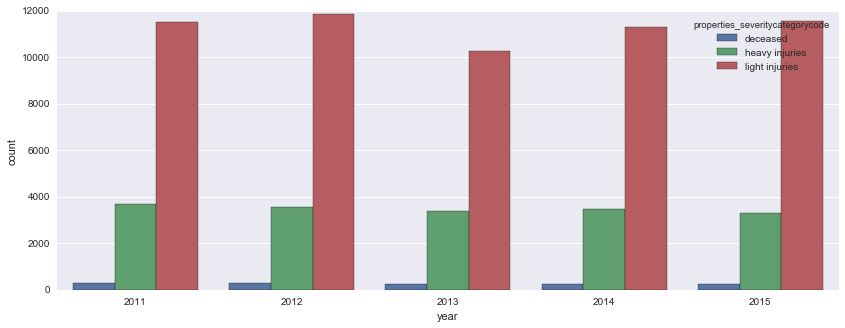

In [19]:
plt.figure(figsize=(14, 5))
sns.countplot(x='year', hue='properties_severitycategorycode', data=accidents_df)

We observe no big variations in accidents in the last 5 years.

In [20]:
accidents_df.year.value_counts(), accidents_df.year.value_counts().mean()

(2012    15709
 2011    15513
 2015    15082
 2014    15009
 2013    13944
 Name: year, dtype: int64, 15051.4)

Average number of accidents over 5 years : 3602.8


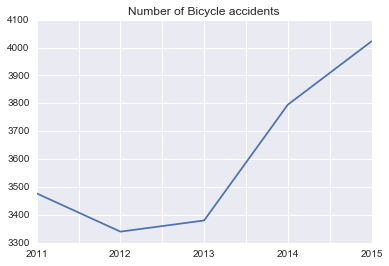

In [21]:
# Bicycle accidents
print('Average number of accidents over 5 years :', accidents_df[accidents_df.involvesBicycles == True].year.value_counts().mean())
accidents_df[accidents_df.involvesBicycles == True].year.value_counts().sort_index().plot(title='Number of Bicycle accidents')

We observe that the number of Bicycle accidents has strongly increased since 2013

Average number of accidents over 5 years : 3915.8


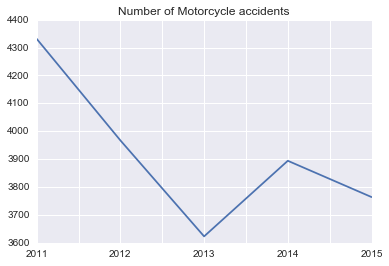

In [22]:
# Motorcycle accidents
print('Average number of accidents over 5 years :', accidents_df[accidents_df.involvesMotorcycles == True].year.value_counts().mean())
accidents_df[accidents_df.involvesMotorcycles == True].year.value_counts().sort_index().plot(title='Number of Motorcycle accidents')

Average number of accidents over 5 years : 2336.0


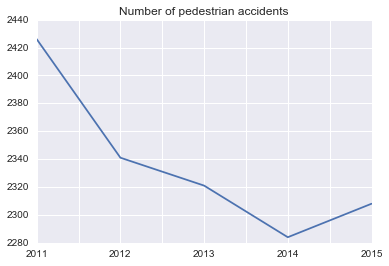

In [23]:
# Pedestrian accidents
print('Average number of accidents over 5 years :', accidents_df[accidents_df.involvesPedestrians == True].year.value_counts().mean())
accidents_df[accidents_df.involvesPedestrians == True].year.value_counts().sort_index().plot(title='Number of pedestrian accidents')

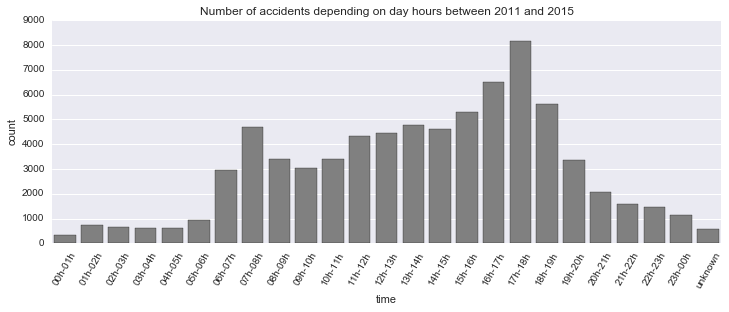

In [24]:
fig, ax = plt.subplots()
fig.set_size_inches(12, 4)
g = sns.countplot(x='time', data=accidents_df, color='grey')
g.set_xticklabels(g.get_xticklabels(), rotation=60)
plt.title('Number of accidents depending on day hours between 2011 and 2015')
plt.show()

This plot shows two peaks of accidents located around 7-8am and 5-6pm, which makes sense since it corresponds to the periods of time where people go to work and go back home, so the traffic is the most dense.
One can imagine that there are more accident in the evening because people are tired or eager to get back home.

Accidents distribution over the whole set of data (2011-2015) : Hour of day

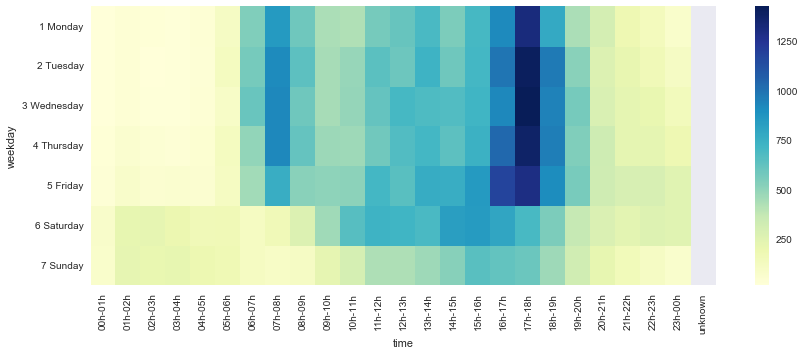

In [25]:
plt.figure(figsize=(14, 5))
time_aware_accidents_df = accidents_df[(accidents_df.time != 'unknown')]
time_aware_accidents_df = time_aware_accidents_df[['time', 'weekday']]
time_aware_accidents_df = time_aware_accidents_df.reset_index()
time_aware_accidents_df = time_aware_accidents_df.groupby(('weekday', 'time')).count().reset_index()
time_aware_accidents_df = time_aware_accidents_df.pivot('weekday', 'time', 'id')
sns.heatmap(time_aware_accidents_df, cmap="YlGnBu")

This heatmap confirms the results of the previous plots, as most accidents occur between 5pm and 6pm, only during weekdays, as the density of traffic at that time is due to the end of workdays.

Accidents distribution over the whole set of data (2011-2015) : Day of month

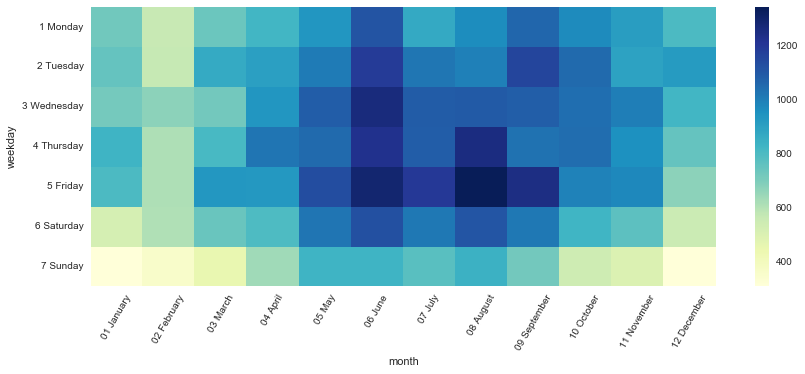

In [26]:
plt.figure(figsize=(14, 5))
time_aware_accidents_df = accidents_df[(accidents_df.time != 'unknown')]
time_aware_accidents_df = time_aware_accidents_df[['month', 'weekday']]
time_aware_accidents_df = time_aware_accidents_df.reset_index()
time_aware_accidents_df = time_aware_accidents_df.groupby(('weekday', 'month')).count().reset_index()
time_aware_accidents_df = time_aware_accidents_df.pivot('weekday', 'month', 'id')
g = sns.heatmap(time_aware_accidents_df, cmap="YlGnBu")
g.set_xticklabels(g.get_xticklabels(), rotation=60)
plt.show()

This heatmap contradicts our initial beliefs. We assumed at first that there would be more accidents during the winter season due to the meteorological conditions (rain, frozen roads), but the data shows us that the most dense period of the year in terms of accidents is the summer season.
This result might be caused by the fact that during winter, drivers are more careful, knowing the risks that come with winter, while during summer, drivers tend to drive faster.

Accidents distribution over the whole set of data (2011-2015) : Month

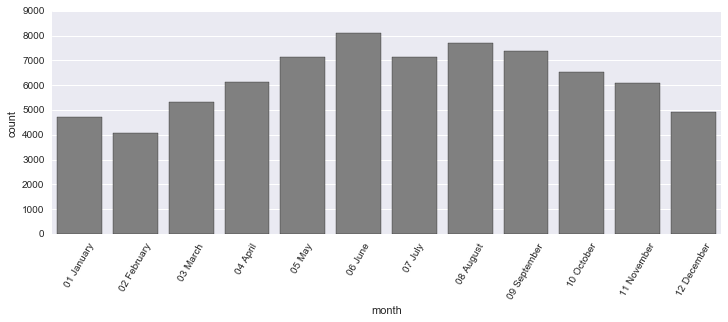

In [27]:
fig, ax = plt.subplots()
fig.set_size_inches(12, 4)
g = sns.countplot(x='month', data=accidents_df, color='grey')
g.set_xticklabels(g.get_xticklabels(), rotation=60)
plt.show()

Accidents distribution over the whole set of data (2011-2015) : Road type per day of week

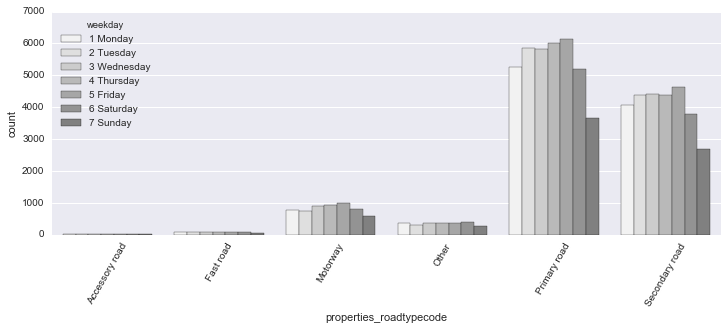

In [28]:
fig, ax = plt.subplots()
fig.set_size_inches(12, 4)
g = sns.countplot(x='properties_roadtypecode', hue='weekday', data=accidents_df, color='grey')
g.set_xticklabels(g.get_xticklabels(), rotation=60)
plt.show()

# Vizualisation

This heatmap shows the accidents density (all accidents type).

Clicking on the top right button allows the user to select the year(s) to display

In [29]:
accidents_df.to_json('data/accidents.json', orient='index')

In [30]:
%%html
<iframe src="heatmap.html" width="1000px" height="600px"></iframe>

## Grid

Our idea is to create squares all over the swiss map to create areas and then count the accident per area.

Swiss coordinates system is designed so that no two x and y coordinates can be mixed, 1 unit is one meter on the field.

min coord Y : 480000, 070000 (bottom left)
max coord X : 840000, 300000 (top right)

There are squares that are outside Switzerland, but we are not interested in areas with 0 value (as if there are no roads, there cannot be any accident either).

In [31]:
def create_grid_per_year(all_data_df, square_size):
    grid_count_list = list()
    years = [2011, 2012, 2013, 2014, 2015]
    for year in years:
        filterer_year_df = all_data_df[all_data_df['year'] == year]
        year_grid = create_count_grid(square_size, filterer_year_df)
        grid_count_list.append(year_grid)
    return grid_count_list

In [32]:
def create_count_grid(square_size, df):
    """
        Creates and fills an array with the count of accidents per squares
        of size square_size on the map with the provided DataFrame df.
    """
    
    xRange=840000-480000
    yRange=300000-70000

    nb_x = math.ceil(xRange/square_size)
    nb_y = math.ceil(yRange/square_size)
    
    grid = np.zeros((nb_x, nb_y))
    #print(nb_x, nb_y, square_size, grid.shape)
    
    for index, row in df.iterrows():
        x = math.floor((row['geometry_coordinates'][0] - 480000) / square_size)
        y = math.floor((row['geometry_coordinates'][1] - 70000) / square_size)
        grid[x, y] += 1
    return grid

In [33]:
def create_grid_per_year(all_data_df, square_size):
    '''
        creates a grid per year in our data set
    '''
    grid_count_list = list()
    years = [2011, 2012, 2013, 2014, 2015]
    for year in years:
        filterer_year_df = all_data_df[all_data_df['year'] == year]
        year_grid = create_count_grid(square_size, filterer_year_df)
        grid_count_list.append(year_grid)
    return grid_count_list

In [34]:
def generate_goejson_polygon(point, year, square_size):
    '''
        This function generates a geojson polygon for a square area computed using the 
        coordinates of the lower left corner of the area.
    '''
    #print(point)
    p1, p2, p3, p4 = find_square_coords(point, square_size)
    s='''{ "type": "Polygon", "year":%d,
    "coordinates": [
        [ [%3f, %3f], [%3f, %3f], [%3f, %3f], [%3f, %3f], [%3f, %3f] ]
      ]
   }\n'''%(year, p1[0], p1[1], p4[0], p4[1], p3[0], p3[1], p2[0], p2[1], p1[0], p1[1])
    return s

In [35]:
def find_square_coords(point_coords, square_size):
    '''
        Given 4 points, returns the wgs84 coordinates
    '''
    xOffset = 480000
    yOffset = 70000
    
    x1 = point_coords[0]*square_size + xOffset
    y1 = point_coords[1]*square_size + yOffset
    
    x2, y2, x3, y3, x4, y4 = find_surrounding_points(x1, y1, square_size)
    
    p1 = ch1903_to_wgs84(x1, y1)
    p2 = ch1903_to_wgs84(x2, y2)
    p3 = ch1903_to_wgs84(x3, y3)
    p4 = ch1903_to_wgs84(x4, y4)
    
    return p1, p2, p3, p4

In [36]:
def find_surrounding_points(x, y, square_size):
    '''
        Compute the coordinates of each corner of the square area based on the coordinates
        of the lower left corner of the area.
    '''
    x2 = x+square_size
    y2 = y
    
    x3 = x2
    y3 = y+square_size
    
    x4 = x
    y4 = y3

    return x2, y2, x3, y3, x4, y4

In [37]:
def geojson_highest_variance_areas(df, square_size, threshold=5):
    '''
        Write the file containing the geoJSON coords of squares with high variance
    '''
    year_grids = create_grid_per_year(df, square_size)
    comp_grids = [np.abs(year_grids[i] - year_grids[i+1]) for i in range(len(year_grids) - 1)]

    polygons='''{
      "type": "Feature",    
      "geometry": {
        "type": "GeometryCollection",    
        "geometries": ['''
    year=2012

    for i in range(len(comp_grids)):
        x=comp_grids[i]
        where = np.where(x > x.max() - threshold)
        if(i!=0):
            polygons+=','

        for j in range(len(where[0])):
            if(j!=0):
                polygons+=','
            point=list()
            point.append(where[0][j])
            point.append(where[1][j])
            polygons+=(generate_goejson_polygon(point, year, square_size))

        year+=1

    polygons+=''']
      },
      "properties": {
        "name": "null island"
      }
    }'''

    polygons=polygons.replace('\n', "")

    with open("data/high_variance_areas.json", "w") as text_file:
                    text_file.write(polygons)

Finding the good square dimensions

In [38]:
def compute_ratio(grid):
    """
        To find a good square size length, we compute a ratio that is (% of non empty squares)/(mean of non zero values)
    """
    non_empty_indices = np.nonzero(grid)
    grid_non_zero = grid[non_empty_indices]
    
    non_empty_pct = len(non_empty_indices) / (grid.shape[0] * grid.shape[1])
    
    mean = grid.mean()
    mean_non_zero = grid_non_zero.mean()
    
    return non_empty_pct / mean_non_zero, non_empty_pct / mean

In [39]:
def optimality_plot(df):
    """
        Plot the result of the ratio per square length, min is better
    """
    optimality_list = [[i, compute_ratio(create_count_grid(i, df))] for i in range (500, 15000, 1000)]
    xaxis = list()
    non_zero = list()
    mean = list()

    for item in optimality_list:
            xaxis.append(item[0])
            non_zero.append(item[1][0])
            mean.append(item[1][1])
    return xaxis, non_zero, mean

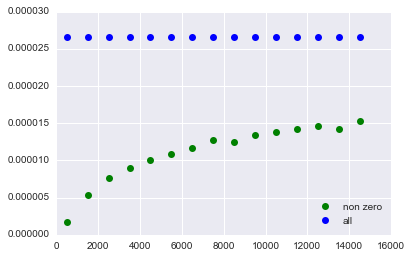

In [40]:
xaxis, non_zero, mean = optimality_plot(accidents_df)
plt.plot(xaxis, non_zero, 'go', label='non zero')
plt.plot(xaxis, mean, 'bo', label='all')
plt.legend(loc='lower right')
plt.show()

We choose the value 1000 as the ratio is good enough and if the square size is too small we wouldn't find interesting accident location changes 

We can now run the pipeline for computing the coordinates of the areas with highest variances in the number of accidents

In [41]:
geojson_highest_variance_areas(accidents_df, 1000, 5)

In [42]:
%%html
<iframe src="heatmap_w_grid.html" width="1000px" height="600px"></iframe>

The red squares in this heatmap represent the areas with the highest variation in the number of accidents between two given year.
Unluckily we found that most results are representing cities area, and the high different isn't really big if we take into account the hole city.

La Poya bridge : The pin in Fribourg is here to show an area in which we observed an interesting change in the number of accidents but that our algorithm did not find. The opening of the bridge, "Pont de la Poya", in late 2014 has caused a massive decrease in the number of accidents in the area. Since the bridge opened, the area marked by the pin has had its traffic load greatly decrease, causing at the same time a decrease in the number of accidents, since a big portion of that traffic is now redirected through the bridge.

Lenzburg : we observed that in Lenzburg there are significantly more accidents in 2012 and 2015 at the highway exit, but couldn't find out if there is a particular reason. If course the urbanism has changed throughout the years in https://map.geo.admin.ch we can enable a historical layer and here are the map form 2007 and now:
![Image](Resources/images/lenz_2007_2.png) ![Image](Resources/images/lenz_now_2.png)